# DATABASE INTERACT WITH PYTHON 

In [6]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Ss@858585',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'E:/Users/archive (1)'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

Matplotlib is building the font cache; this may take a moment.


In [9]:
db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = 'Ss@858585',
                             database = 'ecommerce')
cur = db.cursor()

# List all unique  cities where customers are located

In [69]:
query = """ SELECT DISTINCT(customer_city) FROM customers """

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data , columns = ['unique_city'])

df.head()



,unique_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# count the number of orders placed in 2017

In [16]:
query = """ SELECT COUNT(order_purchase_timestamp) FROM orders
WHERE YEAR(order_purchase_timestamp) = 2017"""

cur.execute(query)

data = cur.fetchall()

print('The total number of orders placed in 2017 are : ',data [0][0])


The total number of orders placed in 2017 are :  45101


# find the total sales per category

In [28]:
query = """ SELECT UPPER(product_category), 
ROUND(SUM(payment_value),2) AS total_sale FROM products
JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY product_category """

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data , columns = ['category','sales'])

df


,category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentge of orders that were paid in installments.

In [40]:
query = """ SELECT SUM(CASE WHEN payment_installments >= 1 THEN 1
ELSE 0
END) / COUNT(*)*100 total_installment FROM payments"""

cur.execute(query)

data = cur.fetchall()

data

'the percentge of orders that were paid in installments is' , data[0][0]


('the percentge of orders that were paid in installments is',
 Decimal('99.9981'))

# Count the total number of customers from each state.

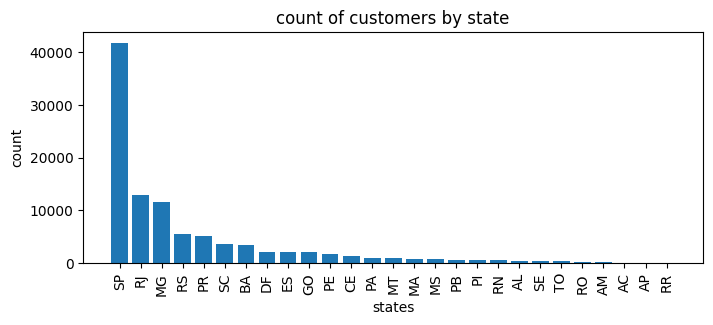

In [101]:
query = """ SELECT customer_state ,COUNT(customer_id) AS count FROM customers
GROUP BY customer_state
ORDER BY count DESC"""

cur.execute(query)

data = cur.fetchall()

data

df=pd.DataFrame(data , columns = ['state','count'])

df

plt.figure(figsize = (8,3))
plt.bar(df['state'],df['count'])
plt.xticks(rotation = 90)
plt.xlabel('states')
plt.ylabel('count')
plt.title('count of customers by state')
plt.show()



# Calculate the number of orders per month in 2018

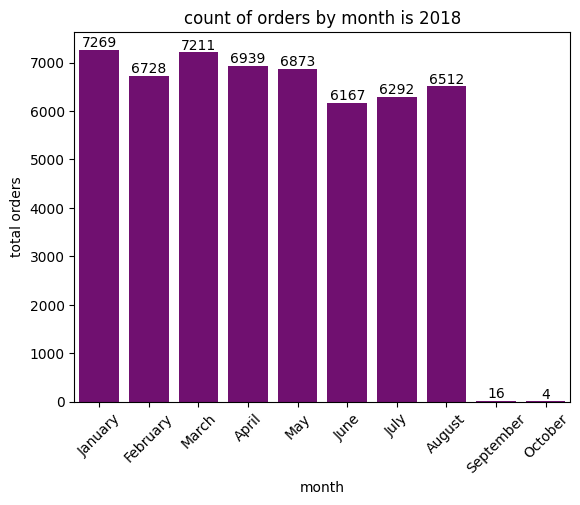

In [105]:
query = """ SELECT MONTHNAME(order_purchase_timestamp) AS months,
COUNT(order_id) AS total_orders FROM orders
WHERE YEAR(order_purchase_timestamp) = 2018
GROUP BY months
ORDER BY total_orders DESC"""

cur.execute(query)

data = cur.fetchall()

data

df=pd.DataFrame(data , columns=['month','total orders'])

#print(df)

O=['January','February','March','April','May','June','July','August','September','October']

ax=sns.barplot( x = df['month'], y = df['total orders'], data = df , order = O , color = 'purple')
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title('count of orders by month is 2018')
plt.show()

# Find the average number of products per order , grouped by customer city.

In [108]:
query = """ WITH count_per_order AS
(SELECT orders.order_id , orders.customer_id,
COUNT(order_items.order_id) AS oc
FROM orders 
JOIN order_items
ON orders.order_id = order_items.order_id
GROUP BY orders.order_id , orders.customer_id)

SELECT customers.customer_city , ROUND(AVG(count_per_order.oc),2)
AS average_orders
FROM customers 
JOIN count_per_order
ON customers.customer_id = count_per_order.customer_id
GROUP BY customers.customer_city
ORDER BY average_orders DESC; """

cur.execute(query)

data = cur.fetchall()

data

df = pd.DataFrame(data , columns = ['customer city' , 'avg/per_order'])

df.head(10)

,customer city,avg/per_order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# calculate the percentage of total revenue contributed by each product category

In [113]:
query = """ SELECT UPPER(product_category), 
ROUND((SUM(payment_value)/(SELECT SUM(payment_value) FROM payments))*100,2) AS sales_percentage FROM products
JOIN order_items
ON products.product_id = order_items.product_id
JOIN payments
ON payments.order_id = order_items.order_id
GROUP BY product_category
ORDER BY sales_percentage DESC"""

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data,columns=['category','sales %'])

df

,category,sales %
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# identify the correlation between product price and the number of times a product has been purcased

In [123]:
query = '''SELECT products.product_category , COUNT(order_item_id) AS total_count , ROUND(AVG(price),2) AS avg_price FROM products
JOIN order_items
ON products.product_id = order_items.product_id
GROUP BY products.product_category;'''

cur.execute(query)

data = cur.fetchall()

df=pd.DataFrame(data , columns = ['product category','total count','avg price'])

arr1 = df['total count']
arr2 = df['avg price']
a=np.corrcoef([arr1,arr2])

print('the correlation between price and number of times a product has been purchased is',a[0][1])


the correlation between price and number of times a product has been purchased is -0.10631514167157562


# Calculate the total revenue genreted by each seller and rank them by revenue

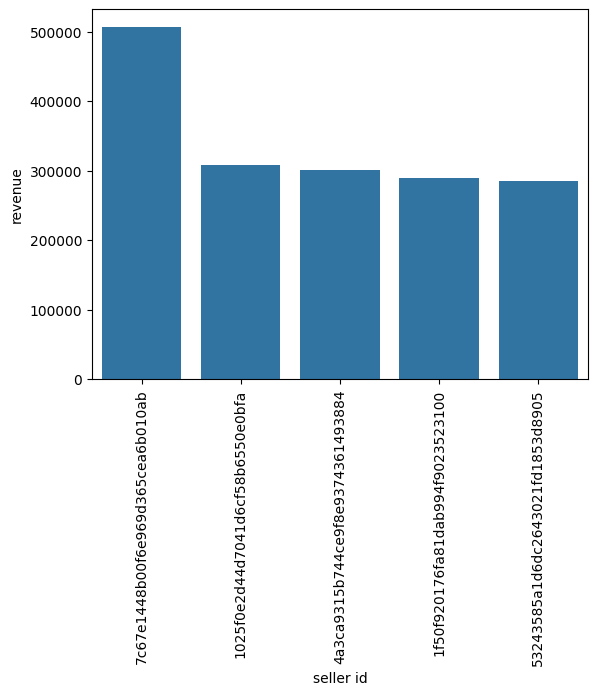

In [131]:
query = '''SELECT order_items.seller_id , SUM(payments.payment_value) AS payment ,
DENSE_RANK()OVER(ORDER BY SUM(payments.payment_value) DESC)
AS ranking FROM order_items
JOIN payments
ON order_items.order_id = payments.order_id
GROUP BY order_items.seller_id;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ['seller id','revenue','Ranking'])

df = df.head(5)
sns.barplot(x = 'seller id', y = 'revenue' , data = df)
plt.xticks(rotation = 90)
plt.show()


# Calculate the moving average of order values for each customer over their order history

In [135]:
query = '''SELECT customer_id , order_purchase_timestamp,
ROUND(AVG(payment) OVER(PARTITION BY customer_id ORDER BY order_purchase_timestamp
ROWS BETWEEN 2 PRECEDING AND CURRENT ROW),2) AS mov_avg
FROM 
(SELECT orders.customer_id , orders.order_purchase_timestamp,
payments.payment_value AS payment
FROM payments 
JOIN orders
ON payments.order_id = orders.order_id) AS a;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ['customer id','order purchase details','moving avg'])

df





,customer id,order purchase details,moving avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01
...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50


# Calculate the cumulative sales per month for each year.

In [170]:
query = '''SELECT years , months , ROUND(SUM(payment)
OVER(ORDER BY years , months),2) AS cumulative_sales FROM
(SELECT YEAR(orders.order_purchase_timestamp) AS years,
MONTH(orders.order_purchase_timestamp) AS months,
ROUND(SUM(payments.payment_value),2) AS payment FROM orders
JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years , months
ORDER BY years , months ASC ) AS a;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ['year','month','cumulutive sum'])

df



,year,month,cumulutive sum
0,2016,9,252.24
1,2016,10,59342.72
2,2016,12,59362.34
3,2017,1,197850.38
4,2017,2,489758.39
5,2017,3,939621.99
6,2017,4,1357410.02
7,2017,5,1950328.84
8,2017,6,2461605.22
9,2017,7,3053988.14


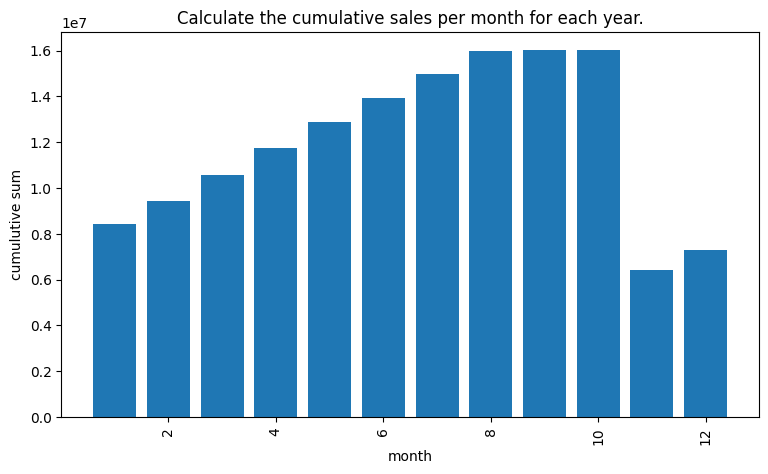

In [181]:

query = '''SELECT years , months , ROUND(SUM(payment)
OVER(ORDER BY years , months),2) AS cumulative_sales FROM
(SELECT YEAR(orders.order_purchase_timestamp) AS years,
MONTH(orders.order_purchase_timestamp) AS months,
ROUND(SUM(payments.payment_value),2) AS payment FROM orders
JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years , months
ORDER BY years , months ASC ) AS a;'''

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data , columns = ['year','month','cumulutive sum'])

plt.figure(figsize = (9,5))
plt.bar(df['month'],df['cumulutive sum'])
plt.xticks(rotation = 90)
plt.xlabel('month')
plt.ylabel('cumulutive sum')
plt.title('Calculate the cumulative sales per month for each year.')
plt.show()

# To Reestablish The Connection 

In [13]:
db = mysql.connector.connect(host = 'localhost',
                             username = 'root',
                             password = 'Ss@858585',
                             database = 'ecommerce')
cur = db.cursor()

# calculate the year over year growth rate of total sales

In [22]:
query = '''WITH a AS(SELECT YEAR(orders.order_purchase_timestamp) as years,
ROUND(SUM(payments.payment_value),2) AS payment FROM orders
JOIN payments
ON orders.order_id = payments.order_id
GROUP BY years 
ORDER BY years)

SELECT years , ((payment - LAG(payment , 1) OVER(ORDER BY years)) /
LAG(payment , 1) OVER(ORDER BY years))*100 FROM a'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame( data , columns = ['years','yoy % growth'])

df

,years,yoy % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# identify the top 3 customers who spent the most money in each year

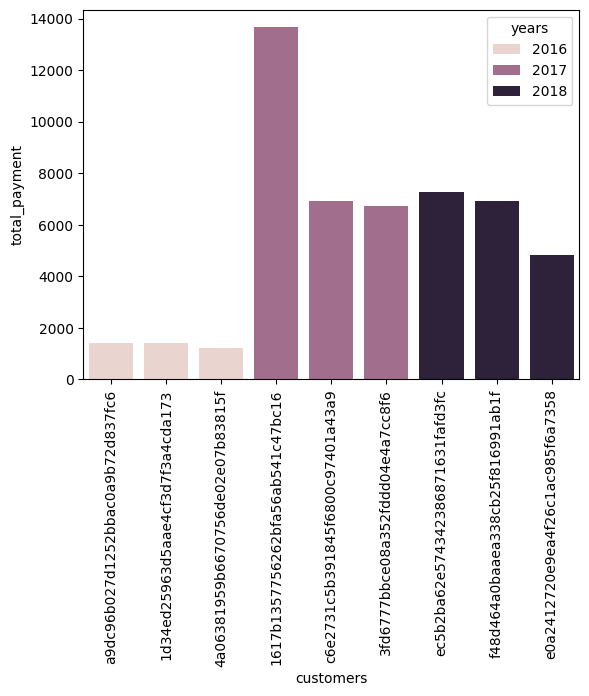

In [34]:
query = '''SELECT year , customers , total_payment ,  overall_rank FROM 
(SELECT customers.customer_id AS customers , YEAR(orders.order_purchase_timestamp) AS year ,
ROUND(SUM(payments.payment_value),2) AS total_payment ,
DENSE_RANK() OVER(PARTITION BY  YEAR(orders.order_purchase_timestamp)
ORDER BY SUM(payments.payment_value) DESC) AS overall_rank FROM customers
JOIN orders
ON customers.customer_id = orders.customer_id
JOIN payments
ON orders.order_id = payments.order_id
GROUP BY customers , year) AS a
WHERE overall_rank <= 3;
'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame( data , columns = ['years','customers','total_payment','overall_rank'])

sns.barplot(x = 'customers', y = 'total_payment' , data = df , hue = 'years')
plt.xticks(rotation = 90)
plt.show()
